In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [14]:
import os
import matplotlib.pyplot as plt
import cv2

In [15]:
TARGET_DIR = "data/train"
TARGET_VAL_DIR = "data/val"

In [16]:
pictures = os.listdir(f"{TARGET_DIR}/target_person")
pictures = pictures[1:]
# pictures

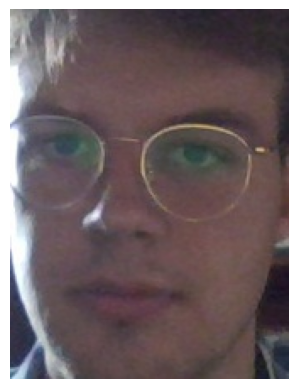

In [17]:
for filename in pictures:
    img_bgr = cv2.imread(f"{TARGET_DIR}/target_person/{filename}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Show image
    plt.imshow(img_rgb)
    plt.axis("off")   # hide axis ticks
    plt.show()
    break

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_HEIGHT, IMG_WIDTH = 170, 220
BATCH_SIZE = 8

train_tfms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder("data/train", transform=train_tfms)
val_dataset   = datasets.ImageFolder("data/val", transform=val_tfms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [19]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes=2, img_height=170, img_width=250):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)

        # compute flattened feature size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_height, img_width)  # [N, C, H, W]
            out = self._forward_convs(dummy)
            n_features = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _forward_convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self._forward_convs(x)
        x = x.view(x.size(0), -1)     # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)   

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FaceCNN(num_classes=len(train_dataset.classes), 
                img_height=IMG_HEIGHT, img_width=IMG_WIDTH).to(device)

criterion = nn.CrossEntropyLoss()  # use this for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [21]:
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # print(f"epoch {epoch} started")
    for images, labels in train_loader:
        # print(f"{images}, {labels}")
        images, labels = images.to(device), labels.to(device)
        print()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▏                                                                         | 1/10 [02:30<22:33, 150.42s/it]

Epoch 1/10 | Loss: 0.3879 | Train Acc: 82.96% | Val Acc: 100.00%


























































































































































































































































 20%|████████████████▍                                                                 | 2/10 [05:02<20:11, 151.39s/it]

Epoch 2/10 | Loss: 0.1908 | Train Acc: 92.97% | Val Acc: 100.00%


























































































































































































































































 30%|████████████████████████▌                                                         | 3/10 [07:35<17:44, 152.03s/it]

Epoch 3/10 | Loss: 0.1488 | Train Acc: 94.64% | Val Acc: 100.00%


























































































































































































































































 40%|████████████████████████████████▊                                                 | 4/10 [10:07<15:11, 151.99s/it]

Epoch 4/10 | Loss: 0.1197 | Train Acc: 96.56% | Val Acc: 100.00%


























































































































































































































































 50%|█████████████████████████████████████████                                         | 5/10 [12:50<12:59, 155.99s/it]

Epoch 5/10 | Loss: 0.0899 | Train Acc: 97.37% | Val Acc: 100.00%


























































































































































































































































 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:32<10:32, 158.13s/it]

Epoch 6/10 | Loss: 0.0770 | Train Acc: 97.72% | Val Acc: 100.00%


























































































































































































































































 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [18:16<07:59, 159.87s/it]

Epoch 7/10 | Loss: 0.0664 | Train Acc: 97.93% | Val Acc: 100.00%


























































































































































































































































 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:59<05:22, 161.05s/it]

Epoch 8/10 | Loss: 0.0652 | Train Acc: 97.67% | Val Acc: 100.00%


























































































































































































































































 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [23:38<02:40, 160.49s/it]

Epoch 9/10 | Loss: 0.0482 | Train Acc: 98.33% | Val Acc: 100.00%


























































































































































































































































100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [26:33<00:00, 159.31s/it]

Epoch 10/10 | Loss: 0.0377 | Train Acc: 98.84% | Val Acc: 100.00%


In [22]:
# After training
torch.save(model.state_dict(), "model2_weights.pth")


In [ ]:
model2 = FaceCNN(num_classes=1, img_height=IMG_HEIGHT, img_width=IMG_WIDTH).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # print(f"epoch {epoch} started")
    for images, labels in train_loader:
        # print(f"{images}, {labels}")
        images, labels = images.to(device), labels.to(device)
        print()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    
    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
torch.save(model2.state_dict(), "model_classification_weights.pth")

In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

In [15]:


# # Load your trained model
# model = MyModelClass(*args)  # replace with your model class
# model.load_state_dict(torch.load("model_weights.pth"))
# model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"

# Transformation to match training
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# Class names
class_names = ["Dominik", "NIE Dominik"]  # replace with your classes

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert OpenCV BGR to PIL RGB
    img_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_tensor = val_tfms(img_pil).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = class_names[predicted.item()]

    # Display label on frame
    cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("Webcam Prediction", frame)

    # Quit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [7]:
import cv2
import torch
from deepface import DeepFace
from torchvision import transforms
from PIL import Image
import numpy as np

In [17]:
class_names = ["NIE Dominik", "Dominik"]

cap = cv2.VideoCapture(0)
frame_count = 0
update_every = 10  # run detection & classification every 10 frames

# Store last predictions and bounding boxes
last_faces_info = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    faces = []

    if frame_count % update_every == 0:
        # Detect faces
        try:
            faces = DeepFace.extract_faces(frame, detector_backend='mtcnn', enforce_detection=False)
        except:
            faces = []

        # Classify each face
        last_faces_info = []
        for face_data in faces:
            cropped_face = face_data["face"]
            cropped_face_uint8 = (cropped_face * 255).astype(np.uint8)
            img_pil = Image.fromarray(cropped_face_uint8)
            img_tensor = val_tfms(img_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(img_tensor)
                _, predicted = torch.max(outputs, 1)
                label = class_names[predicted.item()]

                
                # probs = torch.softmax(outputs, dim=1)      # convert to probabilities
                # confidence, predicted = torch.max(probs, 1)

                # label = str(confidence.item())

            # Save bounding box and label
            area = face_data["facial_area"]
            last_faces_info.append({
                "x": area["x"],
                "y": area["y"],
                "w": area["w"],
                "h": area["h"],
                "label": label
            })

    # Draw the last known boxes and labels (even if no detection this frame)
    for face in last_faces_info:
        x, y, w, h = face["x"], face["y"], face["w"], face["h"]
        # label = face["label"]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.8, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Webcam Face Classification", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'Image' is not defined

In [17]:
model

FaceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=33280, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [1]:
from deepface import DeepFace
import cv2
import numpy as np

In [4]:
img_path = "data/train/target_person/cropped_face80.jpg"
image = cv2.imread(img_path)
models = ["VGG-Face", "Facenet", "OpenFace", "DeepFace", "Dlib", "ArcFace"]
base_embedding = DeepFace.represent(image, model_name = models[2])[0]["embedding"]
base_embedding = np.array(base_embedding)
# base_embedding

In [7]:
cap = cv2.VideoCapture(0)
frame_count = 0
update_every = 10  # run detection & classification every 10 frames

last_faces_info = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    faces = []

    if frame_count % update_every == 0:
        try:
            faces = DeepFace.extract_faces(frame, detector_backend='mtcnn', enforce_detection=False)
        except:
            faces = []

        last_faces_info = []
        for face_data in faces:
            cropped_face = face_data["face"]
            cropped_face_uint8 = (cropped_face * 255).astype(np.uint8)
            try:
                embedding = DeepFace.represent(cropped_face_uint8, model_name=models[2])[0]["embedding"]
                embedding = np.array(embedding)

                cosine_distance = np.dot(embedding, base_embedding) / (
                    np.linalg.norm(embedding) * np.linalg.norm(base_embedding)
                )
                threshold = 0.7
                if cosine_distance > threshold:
                    label = "Dominik"
                    label += f"\n{cosine_distance:.2f}"
                else:
                    label = "NIE Dominik"
                    new_dist = 1 - cosine_distance
                    label += f"\n{new_dist:.2f}"
                # label += f"\n{cosine_distance:.2f}"

                area = face_data["facial_area"]
                last_faces_info.append({
                    "x": area["x"],
                    "y": area["y"],
                    "w": area["w"],
                    "h": area["h"],
                    "label": label
                })
            except Exception as e:
                area = face_data["facial_area"]
                last_faces_info.append({
                    "x": area["x"],
                    "y": area["y"],
                    "w": area["w"],
                    "h": area["h"],
                    "label":str(e)
                })

    # Draw boxes + labels
    for face in last_faces_info:
        x, y, w, h = face["x"], face["y"], face["w"], face["h"]
        label = face["label"]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Webcam Face Classification", frame)

    # ✅ break if window closed (X button) OR if 'q' is pressed
    if cv2.getWindowProperty("Webcam Face Classification", cv2.WND_PROP_VISIBLE) < 1:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [18]:
cap.release()
cv2.destroyAllWindows()